In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pylab as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline



In [2]:
df = pd.read_csv('longtime_ads.csv')

In [3]:
df = df[df['how_long'] <= 60]

In [55]:
kind = []
for idx in range(len(df)):
    i = df.iloc[idx]
    s = ''
    if pd.notna(i['pu_num_days']):
        s += 'Pu'
    if pd.notna(i['sus_num_days']):
        s += 'Sus'
    if pd.notna(i['su_num_days']):
        s += 'Su'
    if pd.notna(i['plus_num_days']):
        s += 'Plus'
    if pd.notna(i['vip_num_days']):
        s += 'Vip'
    kind.append(s)
df['kind'] = kind

In [5]:
df.columns

Index(['pid', 'how_long', 'interest', 'pu_num_days', 'pu_first_day',
       'pu_last_day', 'pu_pay_free', 'pu_pay_point', 'pu_pay_sum',
       'pu_stat_click', 'pu_stat_view', 'sus_num_days', 'sus_first_day',
       'sus_last_day', 'sus_pay_free', 'sus_pay_point', 'sus_pay_sum',
       'sus_stat_click', 'sus_stat_view', 'su_num_days', 'su_first_day',
       'su_last_day', 'su_pay_free', 'su_pay_point', 'su_pay_sum',
       'su_stat_click', 'su_stat_view', 'tp_num_days', 'tp_first_day',
       'tp_last_day', 'tp_pay_free', 'tp_pay_point', 'tp_pay_sum',
       'tdp_num_days', 'tdp_first_day', 'tdp_last_day', 'tdp_pay_free',
       'tdp_pay_point', 'tdp_pay_sum', 'kind'],
      dtype='object')

In [54]:
df.groupby('kind', as_index=False)['pid'].count()

,kind,pid
0,Plus,46
1,Pu,75
2,PuSu,28
3,PuSuPlus,3
4,PuSus,36
5,PuSusSu,38
6,PuSusSuPlus,7
7,PuSusSuPlusVip,1
8,Su,785
9,SuPlus,11


In [29]:
Pu = df[df['kind'] == 'Pu']
(Pu['pu_num_days']/Pu['how_long']).mean()

0.461305703788699

In [32]:
print(Pu['how_long'].mean())
print(Pu['pu_num_days'].mean())

38.666666666666664
16.72


In [7]:
ids = ','.join('\''+str(i)+'\'' for i in df['pid'].unique().tolist())

In [8]:
q = f'''
SELECT i.content_id, sum(v.view_cnt) as view_cnt, sum(i.imp_cnt) as imp_cnt, 
    CASE 
         WHEN sum(i.imp_cnt) = 0 THEN 0 
         ELSE Cast(sum(v.view_cnt) AS FLOAT) / Cast(sum(i.imp_cnt) AS FLOAT) 
       END          AS ctr
FROM   (SELECT imp_id, content_id, 
               COALESCE(Count(*), 0) AS imp_cnt 
        FROM   bun_log_app.app_event_type_impression 
        WHERE  content_id IN ( {ids} ) 
               AND year||month in ('202004', '202003', '202002')
        GROUP  BY imp_id, content_id) AS i 
       LEFT JOIN (SELECT imp_id, content_id, 
                               COALESCE(Count(*), 0) AS view_cnt 
                        FROM   bun_log_app.app_event_type_view 
                        WHERE  content_id IN ( {ids} ) 
                               AND year||month in ('202004', '202003', '202002')
                        GROUP  BY imp_id, content_id) v 
                    ON i.imp_id = v.imp_id
group by i.content_id
'''
df_ctr = pd.read_sql(q, con=redshift)

In [10]:
df_ctr.columns = ['pid', 'view_cnt', 'imp_cnt', 'ctr']

In [12]:
df_ctr['pid'] = df_ctr['pid'].astype(int)
df['pid'] = df['pid'].astype(int)

In [27]:
df = pd.merge(df, df_ctr, on='pid')

NameError: name 'df_ctr' is not defined

In [26]:
df.columns

Index(['pid', 'how_long', 'interest', 'pu_num_days', 'pu_first_day',
       'pu_last_day', 'pu_pay_free', 'pu_pay_point', 'pu_pay_sum',
       'pu_stat_click', 'pu_stat_view', 'sus_num_days', 'sus_first_day',
       'sus_last_day', 'sus_pay_free', 'sus_pay_point', 'sus_pay_sum',
       'sus_stat_click', 'sus_stat_view', 'su_num_days', 'su_first_day',
       'su_last_day', 'su_pay_free', 'su_pay_point', 'su_pay_sum',
       'su_stat_click', 'su_stat_view', 'tp_num_days', 'tp_first_day',
       'tp_last_day', 'tp_pay_free', 'tp_pay_point', 'tp_pay_sum',
       'tdp_num_days', 'tdp_first_day', 'tdp_last_day', 'tdp_pay_free',
       'tdp_pay_point', 'tdp_pay_sum', 'kind'],
      dtype='object')

In [16]:
df.groupby('kind', as_index=False)['ctr'].mean().sort_values('ctr', ascending=False)

,kind,ctr
10,Sus,0.053773
8,Su,0.044572
14,Vip,0.041976
12,SusSu,0.041944
2,PuSu,0.036719
5,PuSusSu,0.033824
1,Pu,0.031736
0,Plus,0.030543
4,PuSus,0.026584
3,PuSuPlus,0.026405


In [28]:
df= pd.read_csv('longtimeselling_ctr.csv')

In [33]:
df = df[df['ctr'] < 1]

In [47]:
ids = ','.join('\''+str(i)+'\'' for i in df.sort_values('ctr', ascending=False)[:100]['pid'].tolist())

In [52]:
q = f'''
select id as pid, uid, name, category_id
from service1_quicket.product_info
where id in ({ids})
'''
top_products = pd.read_sql(q, con=redshift)

In [62]:
top_pids = pd.merge(df.sort_values('ctr', ascending=False)[:100][['pid', 'kind', 'ctr']], top_products, on ='pid')

In [64]:
top_pids.sort_values('ctr', ascending=False)[:20]

,pid,kind,ctr,uid,name,category_id
0,119293868,Sus,0.254199,5598818,에어팟2 미개봉 무선 OEM 판매합니다.,600700001
1,119198773,Sus,0.227637,6061587,뉴발란스 992 그레이,400040100
2,119600219,Su,0.224290,173086,2주우머나이저 세티스파이 충전식 아답터 포함,600400005
3,118804909,Sus,0.218065,7517218,슈프림 에어포스 화이트,400040999
4,118817639,Sus,0.200131,7630043,아우디A6 깔끔한 바디킷 정확한 가속력 가성비수입차~,750
5,120474475,Sus,0.197792,6370874,"bhc뿌링클치즈볼,골드킹치즈볼,교촌 허니콤포 웨지감자 기프티콘 삽니다",800300999
6,118586816,Plus,0.188746,4392378,살아있는 라이브활킹크랩,800300003
7,119311806,Sus,0.187317,5081034,미스터트롯인천싸게 ■ 1층 최고구역 ■ 1~2연석,900210001
8,120953175,Sus,0.180363,6317440,자바 퓨리아 풀샥,700350300
9,118358992,Su,0.179076,10276352,❤최저가❤ 마인크래프트 PC 정품 자바에디션 코드키,600600005


In [60]:
category = [i[:3] for i in top_pids['category_id'].astype(str).tolist()]
top_pids['one_depth'] = category
top_pids.groupby('one_depth')['pid'].count()

one_depth
310     1
320     6
400    18
410     2
500     1
600    37
700     2
750    21
800     5
900     3
999     4
Name: pid, dtype: int64

In [30]:
df = df[['pid', 'how_long', 'interest', 'view_cnt', 'imp_cnt', 'ctr', 'pu_num_days',
       'pu_first_day', 'pu_last_day', 'pu_pay_free', 'pu_pay_point',
       'pu_pay_sum', 'pu_stat_click', 'pu_stat_view', 'sus_num_days',
       'sus_first_day', 'sus_last_day', 'sus_pay_free', 'sus_pay_point',
       'sus_pay_sum', 'sus_stat_click', 'sus_stat_view', 'su_num_days',
       'su_first_day', 'su_last_day', 'su_pay_free', 'su_pay_point',
       'su_pay_sum', 'su_stat_click', 'su_stat_view', 'tp_num_days',
       'tp_first_day', 'tp_last_day', 'tp_pay_free', 'tp_pay_point',
       'tp_pay_sum', 'tdp_num_days', 'tdp_first_day', 'tdp_last_day',
       'tdp_pay_free', 'tdp_pay_point', 'tdp_pay_sum']]
df.columns = ['pid', 'how_long', 'interest', 'view_cnt', 'imp_cnt', 'ctr', 'pu_num_days',
       'pu_first_day', 'pu_last_day', 'pu_pay_free', 'pu_pay_point',
       'pu_pay_sum', 'pu_stat_click', 'pu_stat_view', 'sus_num_days',
       'sus_first_day', 'sus_last_day', 'sus_pay_free', 'sus_pay_point',
       'sus_pay_sum', 'sus_stat_click', 'sus_stat_view', 'su_num_days',
       'su_first_day', 'su_last_day', 'su_pay_free', 'su_pay_point',
       'su_pay_sum', 'su_stat_click', 'su_stat_view', 'plus_num_days',
       'plus_first_day', 'plus_last_day', 'plus_pay_free', 'plus_pay_point',
       'plus_pay_sum', 'vip_num_days', 'vip_first_day', 'vip_last_day',
       'vip_pay_free', 'vip_pay_point', 'vip_pay_sum']

In [31]:
df.to_csv('longtimeselling_ctr.csv', index=False)

In [74]:
Sus = df[df['kind'] == 'Sus']

In [23]:
sus_temp = Sus[['pid', 'view_cnt', 'imp_cnt', 'ctr']].sort_values('ctr', ascending=False)[:50]

In [26]:
ids = ','.join('\''+str(i)+'\'' for i in sus_temp['pid'].unique().tolist())

In [27]:
ids

"'119293868','119198773','118804909','118817639','120474475','119311806','120953175','120523359','121708201','118879859','120739533','120901181','119959728','119368546','121197130','118908297','121413284','118954791','118352810','119585643','118484770','119536903','121452088','119399196','121108883','119134657','118635326','119118950','119898108','120614229','120646394','118407450','120749121','118618582','119237197','119728408','119644428','119386498','118675304','121326023','119699469','119818698','120526043','121726988','119896800','118793388','119963044','118548857','118796391','118216806'"

In [33]:
q = f'''
select id as pid, name, left(category_id, 3) as category_id
from service1_quicket.product_info
where id in ({ids})
'''

t = pd.read_sql(q, con=redshift)

In [34]:
sus_temp = pd.merge(sus_temp, t, on='pid')

In [37]:
sus_temp.columns = ['pid', 'click_cnt', 'imp_cnt', 'ctr', 'name', 'category_id']

In [65]:
sus_temp = pd.merge(df[['pid', 'how_long', 'sus_num_days', 'sus_pay_sum', 'sus_first_day', 'sus_last_day']], sus_temp, on='pid').sort_values('ctr',ascending=False)

NameError: name 'sus_temp' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['ctr'], bins='auto')

(array([ 35.,  52., 108., 141., 168., 239., 224., 225., 181., 163., 110.,
        107.,  91.,  77.,  66.,  50.,  47.,  44.,  33.,  27.,  20.,  21.,
         23.,  16.,  11.,   6.,  10.,  14.,   6.,   6.,   4.,   5.,   3.,
          1.,   1.,   1.,   1.,   3.,   1.,   1.,   1.,   1.,   1.,   0.,
          0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00121534, 0.00590022, 0.01058509, 0.01526997, 0.01995485,
        0.02463973, 0.02932461, 0.03400949, 0.03869437, 0.04337925,
        0.04806413, 0.05274901, 0.05743389, 0.06211877, 0.06680365,
        0.07148853, 0.07617341, 0.08085828, 0.08554316, 0.09022804,
        0.09491292, 0.0995978 , 0.10428268, 0.10896756, 0.11365244,
        0.11833732, 0.1230222 , 0.12770708, 0.13239196, 0.13707684,
        0.14176172, 0.1464466 , 0.15113147, 0.15581635, 0.16050123,
        0.16518611, 0.16987099, 0.17455587, 0.17924075, 0.18392563,
        0.18861051, 0.19329539, 0.19798027, 0.20266515, 0.20735003,
        0.21203491, 0.

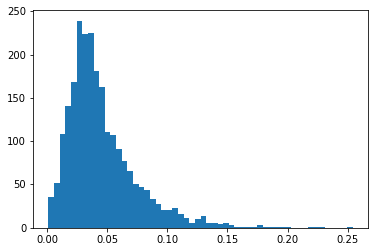

In [55]:
import matplotlib.pyplot as plt

plt.hist(df['ctr'], bins='auto')

In [58]:
Su = df[df['kind'] == 'Su']

In [63]:
Su[['pid', 'how_long', 'su_num_days', 'view_cnt', 'imp_cnt', 'ctr']].sort_values('ctr', ascending=False)[:20]

,pid,how_long,su_num_days,view_cnt,imp_cnt,ctr
2034,119600219,38,1.0,1217,5426,0.224290
1800,118358992,54,51.0,6186,34544,0.179076
1865,118686980,49,7.0,1416,8283,0.170953
2186,120606134,27,240.0,1582,10356,0.152762
2215,120856579,24,7.0,5099,34235,0.148941
2129,120249035,31,12.0,1072,7221,0.148456
2047,119679596,37,1.0,1480,10053,0.147220
2052,119684613,37,7.0,963,6725,0.143197
1136,119585643,38,50.0,3975,28164,0.141138
2194,120638411,27,21.0,11722,83482,0.140414


In [15]:
ids = ','.join('\''+str(i)+'\'' for i in df[df['interest'] > 10000]['pid'].unique().tolist())

In [20]:
big = df[df['interest'] > 10000]

In [17]:
q = f'''
SELECT i.content_id, i.imp_id, i.date as imp_date, v.date as view_date
FROM   (SELECT imp_id, content_id, year||'-'||month||'-'||day as date
        FROM   bun_log_app.app_event_type_impression 
        WHERE  content_id IN ( {ids} ) 
               AND year = '2020') AS i 
       LEFT JOIN (SELECT imp_id, content_id, year||'-'||month||'-'||day as date 
                        FROM   bun_log_app.app_event_type_view 
                        WHERE  content_id IN ( {ids} ) 
                               AND year = '2020') v 
                    ON i.imp_id = v.imp_id and i.content_id = v.content_id
'''
log = pd.read_sql(q, con=redshift)

In [19]:
log.to_csv('log.csv')

In [24]:
big.groupby('kind')['pid'].count()

kind
Plus               2
Pu                 1
PuSus              2
PuSusSuPlusVip     1
Su                13
Sus               10
SusSu              6
SusSuPlus          1
Name: pid, dtype: int64

In [6]:
# sus_log.to_csv('sus_log.csv')
sus_log = pd.read_csv('sus_log.csv')

In [70]:
sus_log['imp_date'] = pd.to_datetime(sus_log['imp_date'])

In [71]:
sus_log['view_date'] = pd.to_datetime(sus_log['view_date'])

In [75]:
Sus = Sus[['pid', 'sus_first_day', 'sus_last_day']]

In [76]:
Sus.sus_first_day = pd.to_datetime(Sus.sus_first_day)
Sus.sus_last_day = pd.to_datetime(Sus.sus_last_day)

In [79]:
sus_log.columns = ['pid', 'imp_id', 'imp_date', 'view_date']

In [81]:
sus_log['pid'] = sus_log['pid'].astype(int)
Sus['pid'] = Sus['pid'].astype(int)

In [82]:
Sus = pd.merge(Sus, sus_log, on = 'pid', how='right')

In [83]:
Sus

,pid,how_long,interest,sus_first_day,sus_last_day,sus_num_days,sus_pay_sum,imp_id,imp_date,view_date
0,118179342,56,2864,2020-02-11,2020-04-22,71.0,9588996.0,None,2020-03-09,NaT
1,118179342,56,2864,2020-02-11,2020-04-22,71.0,9588996.0,97a35e65c8f547965872,2020-03-09,NaT
2,118179342,56,2864,2020-02-11,2020-04-22,71.0,9588996.0,994b5e65caa53322af5a,2020-03-09,NaT
3,118179342,56,2864,2020-02-11,2020-04-22,71.0,9588996.0,97a35e65c9324797ae68,2020-03-09,NaT
4,118179342,56,2864,2020-02-11,2020-04-22,71.0,9588996.0,None,2020-03-09,NaT
...,...,...,...,...,...,...,...,...,...,...
34684615,121744019,14,1580,2020-03-19,2020-04-27,39.0,313000.0,97a45e956ba709303ed7,2020-04-14,NaT
34684616,121744019,14,1580,2020-03-19,2020-04-27,39.0,313000.0,97a45e9569e30920ad2e,2020-04-14,NaT
34684617,121744019,14,1580,2020-03-19,2020-04-27,39.0,313000.0,97dc5e9563a008f1aebb,2020-04-14,NaT
34684618,121744019,14,1580,2020-03-19,2020-04-27,39.0,313000.0,97a45e956946091b5075,2020-04-14,NaT


In [84]:
import numpy as np   
Sus_t = Sus[Sus['view_date'] != np.datetime64('NaT')]
len(Sus_t)

34684620

In [86]:
type(Sus.loc[0,'view_date'])

pandas._libs.tslibs.nattype.NaTType

In [ ]:
no = []
yes = []
for idx in range(len(Sus)):
    i = Sus.iloc[idx]
    if i['imp_date'] >= i['sus_first_day'] and i['imp_date'] <= i['sus_last_day']:
        yes.append(idx)
    else:
        no.append(idx)